In [9]:
import findspark
findspark.init()

In [10]:
import pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

df = spark.sql("select 'spark' as hello ")

df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



In [11]:
from pyspark import SQLContext, SparkContext
sc = SparkContext.getOrCreate()
sql_Context = SQLContext(sc) 

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from pyspark.ml.classification import LinearSVCModel
%matplotlib inline

In [31]:
df = pd.read_csv('CO2_Emissions_Canada.csv');

In [32]:
df.head().T

0        1           2            3            4
Make                    ACURA    ACURA       ACURA        ACURA        ACURA
Model                     ILX      ILX  ILX HYBRID      MDX 4WD      RDX AWD
VehicleClass          COMPACT  COMPACT     COMPACT  SUV - SMALL  SUV - SMALL
EngineSize                  2      2.4         1.5          3.5          3.5
Cylinders                   4        4           4            6            6
Transmission              AS5       M6         AV7          AS6          AS6
FuelType                    Z        Z           Z            Z            Z
FuelConsumptionCity       9.9     11.2           6         12.7         12.1
FuelConsumptionHwy        6.7      7.7         5.8          9.1          8.7
FuelConsumptionComb       8.5      9.6         5.9         11.1         10.6
FuelConsumptionCombG       33       29          48           25           27
CO2Emissions              196      221         136          255          244

### Select some features for the SVM Model

In [33]:
df_features = df[['EngineSize','Cylinders','FuelConsumptionCity','FuelConsumptionHwy','FuelConsumptionComb','CO2Emissions']]
X = df_features.iloc[:,:-1]
y = df_features.iloc[:,-1]

In [34]:
X.head(5)

EngineSize  Cylinders  FuelConsumptionCity  FuelConsumptionHwy  \
0         2.0          4                  9.9                 6.7   
1         2.4          4                 11.2                 7.7   
2         1.5          4                  6.0                 5.8   
3         3.5          6                 12.7                 9.1   
4         3.5          6                 12.1                 8.7   

   FuelConsumptionComb  
0                  8.5  
1                  9.6  
2                  5.9  
3                 11.1  
4                 10.6

In [35]:
y.head(5)

0    196
1    221
2    136
3    255
4    244
Name: CO2Emissions, dtype: int64

### Split data into train and test data 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
X_test.head()

EngineSize  Cylinders  FuelConsumptionCity  FuelConsumptionHwy  \
7261         3.0          6                 12.4                 9.0   
4489         4.4          8                 17.3                11.6   
1539         6.2          8                 16.1                11.4   
3532         5.3          8                 14.6                10.3   
6418         4.0          6                 14.3                11.9   

      FuelConsumptionComb  
7261                 10.9  
4489                 14.7  
1539                 14.0  
3532                 12.7  
6418                 13.2

In [38]:
y_test.head()

7261    253
4489    344
1539    322
3532    297
6418    308
Name: CO2Emissions, dtype: int64

### SVM Regressor

In [39]:
svr = SVR(C=1.0, epsilon=0.2).fit(X_train,y_train)

In [40]:
svr.score(X_test,y_test)

0.83520479200782438

In [41]:
svr.predict(np.array([5.3,8,14.6,10.3,12.7]).reshape(1,-1))

array([ 297.40298748])

In [42]:
print('Explained Variance score: %.2f' % svr.score(X_train, y_train))

Explained Variance score: 0.84


### I try a second model to get a better model accuracy

### I select the same features for multiple regression.

In [43]:
cdf = df[['EngineSize','Cylinders','FuelConsumptionCity','FuelConsumptionHwy','FuelConsumptionComb','CO2Emissions']]
cdf.head(9).T

0      1      2      3      4      5      6      7  \
EngineSize             2.0    2.4    1.5    3.5    3.5    3.5    3.5    3.7   
Cylinders              4.0    4.0    4.0    6.0    6.0    6.0    6.0    6.0   
FuelConsumptionCity    9.9   11.2    6.0   12.7   12.1   11.9   11.8   12.8   
FuelConsumptionHwy     6.7    7.7    5.8    9.1    8.7    7.7    8.1    9.0   
FuelConsumptionComb    8.5    9.6    5.9   11.1   10.6   10.0   10.1   11.1   
CO2Emissions         196.0  221.0  136.0  255.0  244.0  230.0  232.0  255.0   

                         8  
EngineSize             3.7  
Cylinders              6.0  
FuelConsumptionCity   13.4  
FuelConsumptionHwy     9.5  
FuelConsumptionComb   11.6  
CO2Emissions         267.0

### plotting CO2_Emission values with Engine size:

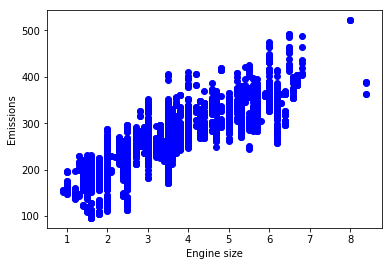

In [44]:
plt.scatter(cdf.EngineSize, cdf.CO2Emissions,  color='blue')
plt.xlabel("Engine size")
plt.ylabel("Emissions")
plt.show()

### Creating train and test dataset¶


In [45]:
msk = np.random.rand(len(df)) < 0.8
train = cdf[msk]
test = cdf[~msk]

### Train data distribution¶


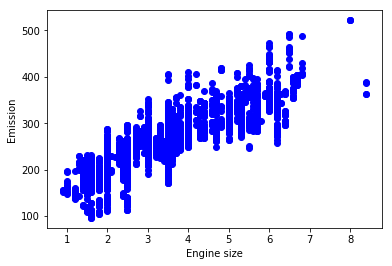

In [46]:
plt.scatter(train.EngineSize, train.CO2Emissions,  color='blue')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

### Multiple Regression Model


In [47]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['EngineSize','Cylinders','FuelConsumptionComb']])
y = np.asanyarray(train[['CO2Emissions']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[  5.38092402   6.45977125  13.3138884 ]]


### Prediction

In [48]:
from sklearn.metrics import r2_score

y_hat= regr.predict(test[['EngineSize','Cylinders','FuelConsumptionComb']])
x = np.asanyarray(test[['EngineSize','Cylinders','FuelConsumptionComb']])
y = np.asanyarray(test[['CO2Emissions']])
print("Residual sum of squares (MSE): %.2f"
      % np.mean((y_hat - y) ** 2))
print("R2-score: %.2f" % r2_score(y_hat , y) )

# Explained variance score: 1 is perfect prediction
print('Explained Variance score: %.2f' % regr.score(x, y))

Residual sum of squares (MSE): 403.49
R2-score: 0.87
Explained Variance score: 0.89
